In [1]:
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm

import plot_set
import model_opt
import algo_GD
import algo_minibatch
import helper
import noise

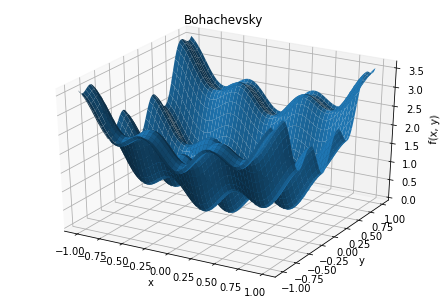

In [2]:
f = model_opt.Bohachevsky()
plot_set.function_value_3d(f,1)

In [3]:
model_func = model_opt.Bohachevsky
w_init = np.array([10,10])
_t_max = 10000
var = 50 # iqr 70~80
noise_data = noise.Gauss(mean=0, sigma=var, dim=2, n=_t_max).generate()

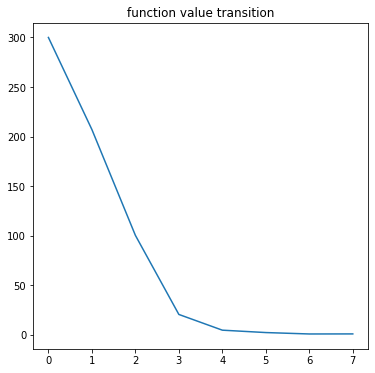

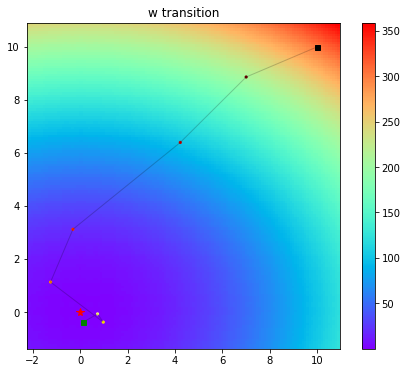

In [4]:

batchsize = 8
tail = 5

algo = algo_minibatch.MinibatchDoublingPartialAveragingSGD(a=0.1, w=w_init, n=_t_max, t=tail, noise_data=noise_data, init_batchsize=batchsize)
algo.tail(model_func = model_func)
w_store_MBDPA = algo.w_store
    

f = model_opt.Bohachevsky()
plot_set.function_value_transition(f,w_store_MBDPA,title="function value transition")
plot_set.w_value_2d_heatmap(f,w_store_MBDPA,_t_max,title="w transition")


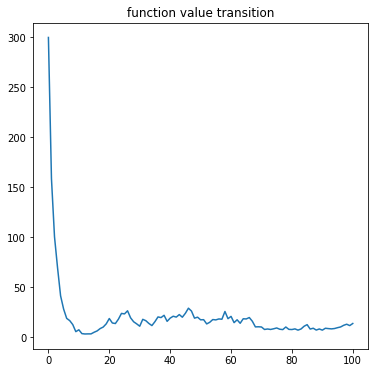

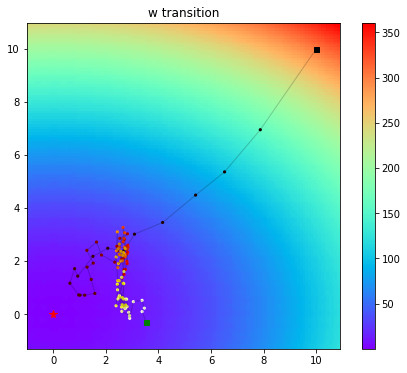

In [5]:
batchsize = 100
_t_max = 10000
tail = 10

algo = algo_minibatch.MinibatchTailAveragingSGD(a=0.1, w=w_init, n=_t_max, s=tail, noise_data=noise_data, batchsize=batchsize)
algo.calculate(model_func=model_func)
w_store_TASGD = algo.w_store



f = model_opt.Bohachevsky()
plot_set.function_value_transition(f,w_store_TASGD,title="function value transition")
plot_set.w_value_2d_heatmap(f,w_store_TASGD,_t_max,title="w transition")

In [6]:
w_init = np.array([5,5])

var = 50 # iqr 70~80
batchsize = 100
_t_max = 10000
noise_data = noise.Gauss(mean=0, sigma=var, dim=2, n=batchsize * _t_max).generate()

algo = algo_GD.SGD(w_init=w_init, t_max=_t_max, a=0.1)
for i in algo:
    f = model_opt.Bohachevsky(noise_value=noise_data[algo.t-1])
    algo.update(model=f)

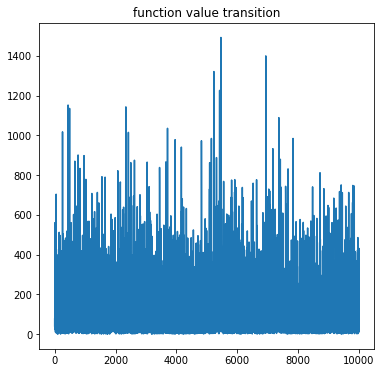

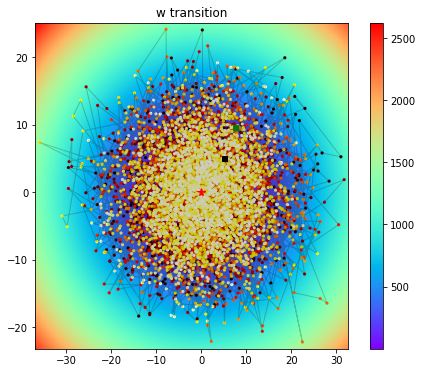

In [7]:
# シンプルなSGD
w_store_SGD = algo.wstore
plot_set.function_value_transition(f,w_store_SGD,title="function value transition")
plot_set.w_value_2d_heatmap(f,w_store_SGD,_t_max,title="w transition")

In [18]:
last_w_MBDPA = []
#それぞれ100回で最終的なwの結果
start = time.time()
# MinibatchDoublingPartialAveragingSGD
for i in tqdm(range(100)):
    noise_data = noise.Gauss(mean=0, sigma=var, dim=2, n=_t_max).generate()
    algo = algo_minibatch.MinibatchDoublingPartialAveragingSGD(a=0.1, w=w_init, n=_t_max, t=tail, noise_data=noise_data, init_batchsize=batchsize)
    w = algo.tail(model_func = model_func)
    last_w_MBDPA.append(w)
end = time.time()
print("MinibatchDoublingPartialAveragingSGD time {}".format(end - start))


# MinibatchTailAveragingSGD
batchsize = 100
_t_max = 10000
tail = 10
last_w_MTASGD = []
start = time.time()
for i in tqdm(range(100)):
    noise_data = noise.Gauss(mean=0, sigma=var, dim=2, n=_t_max).generate()
    algo = algo_minibatch.MinibatchTailAveragingSGD(a=0.1, w=w_init, n=_t_max, s=tail, noise_data=noise_data, batchsize=batchsize)
    w = algo.calculate(model_func=model_func)
    last_w_MTASGD.append(w)
end = time.time()
print("MinibatchTailAveragingSGD time {}".format(end - start))   

last_w_SGD = []    
    

start = time.time()
for i in tqdm(range(100)):
    algo = algo_GD.SGD(w_init=w_init, t_max=_t_max, a=0.1)
    noise_data = noise.Gauss(mean=0, sigma=var, dim=2, n=_t_max).generate()
    for i in algo:
        f = model_opt.Bohachevsky(noise_value=noise_data[algo.t-1])
        algo.update(model=f)
    last_w_SGD.append(algo.w)

end = time.time()
print("SGD time {}".format(end - start)) 
    


MinibatchDoublingPartialAveragingSGD time 0.5167741775512695



MinibatchTailAveragingSGD time 1.128199815750122



SGD time 1948.6129920482635


In [32]:
last_f_MTASGD = f.f_opt(np.array(last_w_MTASGD).T)
last_f_MBDPA = f.f_opt(np.array(last_w_MBDPA).T)
last_f_SGD = f.f_opt(np.array(last_w_SGD).T)

In [35]:
csv = np.stack([last_f_MBDPA,last_f_MTASGD,last_f_SGD],axis=1)

In [36]:
df = pd.DataFrame(csv,columns=['MBDPA', 'MTASGD', 'SGD'])

In [39]:
dt_now = datetime.datetime.now()
df.to_csv('minibatch_f_value/{}.csv'.format(dt_now),header=True)

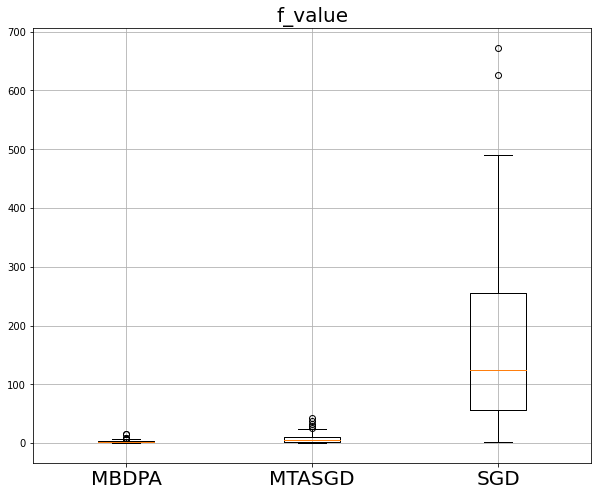

In [43]:

fig = plt.figure(figsize=(10.0, 8.0))
ax1 = fig.add_subplot(111)
noise_box = last_f_MBDPA, last_f_MTASGD,last_f_SGD
bp1 = ax1.boxplot(noise_box)
ax1.set_xticklabels(['MBDPA', 'MTASGD', 'SGD'],fontsize=20)
ax1.set_title('f_value',fontsize=20)
ax1.grid()

plt.show()